In [ ]:
Dataset link: https://www.kaggle.com/datasets/shreelakshmigp/cedardataset

Importing libraries and dataset

In [4]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

In [2]:
# Paths to the folders
full_forg_path = "signatures\\full_forg"
full_org_path = "signatures\\full_org"

# Initialize data lists
train_data = []
train_labels = []
test_data = []
test_labels = []

In [5]:
# Function to process images and append to respective lists
def process_images(folder_path, label, train_list, test_list, train_labels_list, test_labels_list):
    images = sorted(os.listdir(folder_path))  # Sorted image files
    for idx, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        if img_path.endswith(('.jpeg', '.JPEG', '.png', '.PNG', '.jpg', '.JPG')):
            image = cv2.imread(img_path)
            if image is None:  # Skip if image can't be read
                continue
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (64, 64))
            if idx < len(images) * 0.3:  # First 10% of images for testing
                test_list.append(image)
                test_labels_list.append(label)
            else:  # Remaining images for training
                train_list.append(image)
                train_labels_list.append(label)

# Process genuine signatures
process_images(full_org_path, 0, train_data, test_data, train_labels, test_labels)

# Process forged signatures
process_images(full_forg_path, 1, train_data, test_data, train_labels, test_labels)

# Normalize the image data
train_data = np.array(train_data) / 255.0
train_labels = np.array(train_labels)

test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

print(f"Training data size: {train_data.shape}")
print(f"Training labels size: {train_labels.shape}")
print(f"Testing data size: {test_data.shape}")
print(f"Testing labels size: {test_labels.shape}")

Training data size: (1848, 64, 64)
Training labels size: (1848,)
Testing data size: (792, 64, 64)
Testing labels size: (792,)


In [6]:
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((64, 64), name='img_A_inp')
img_B_inp = Input((64, 64), name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((64, 64, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 64, 64)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 64, 64)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 64)        │  1,586,496 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential_4[0][… │
│ (Concatenate)       │                   │            │ sequential_4[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,594,817 (6.08 MB)

 Trainable params: 1,592,897 (6.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
import itertools
import numpy as np

# Updated make_paired_dataset function
def make_paired_dataset(X, y):
    X_pairs, y_pairs = [], []

    # Create tuples of (image, label)
    tuples = [(x1, y1) for x1, y1 in zip(X, y)]

    for t in itertools.product(tuples, tuples):
        pair_A, pair_B = t
        img_A, label_A = pair_A
        img_B, label_B = pair_B

        # Ensure labels are scalar values
        if isinstance(label_A, np.ndarray) and label_A.size > 1:
            raise ValueError(f"Expected scalar labels, but got array: {label_A}")
        if isinstance(label_B, np.ndarray) and label_B.size > 1:
            raise ValueError(f"Expected scalar labels, but got array: {label_B}")
        
        label_A = label_A.item() if isinstance(label_A, np.ndarray) else label_A
        label_B = label_B.item() if isinstance(label_B, np.ndarray) else label_B

        # Assign label for the pair
        new_label = int(label_A == label_B)

        X_pairs.append([img_A, img_B])
        y_pairs.append(new_label)

    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)

    return X_pairs, y_pairs

# Ensure that train_labels and test_labels are 1D arrays
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

# Debugging shape
print(f"Train labels shape after squeezing: {train_labels.shape}")
print(f"Test labels shape after squeezing: {test_labels.shape}")

# Sampling and pairing
random_indices = np.random.choice(train_data.shape[0], 30, replace=False)
X_train_sample, y_train_sample = train_data[random_indices], train_labels[random_indices]

random_indices = np.random.choice(test_data.shape[0], 10, replace=False)
X_test_sample, y_test_sample = test_data[random_indices], test_labels[random_indices]

train_pairs, train_pair_labels = make_paired_dataset(X_train_sample, y_train_sample)
print("Train pairs shape:", train_pairs.shape)
print("Train pair labels shape:", train_pair_labels.shape)

test_pairs, test_pair_labels = make_paired_dataset(X_test_sample, y_test_sample)
print("Test pairs shape:", test_pairs.shape)
print("Test pair labels shape:", test_pair_labels.shape)


Train labels shape after squeezing: (1848,)
Test labels shape after squeezing: (792,)
Train pairs shape: (900, 2, 64, 64)
Train pair labels shape: (900,)
Test pairs shape: (100, 2, 64, 64)
Test pair labels shape: (100,)


In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10)

In [ ]:
model.fit(
    x=[train_pairs[:, 0, :, :], train_pairs[:, 1, :, :]],
    y=train_pair_labels,
    validation_data=(
        [test_pairs[:, 0, :, :], test_pairs[:, 1, :, :]],
        test_pair_labels
    ),
    epochs=40,
    batch_size=16,
    callbacks=[es]
)

Epoch 1/40
 6/57 ━━━━━━━━━━━━━━━━━━━━ 9:02 11s/step - accuracy: 0.5913 - loss: 0.7319

In [11]:
# Save the model in SavedModel format
model.save("saved_model")

# Save the model in HDF5 format (optional)
model.save("model.h5")
model.save_weights("weights.h5")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
/Users/mrinmoy/miniforge3/envs/aiml_stuff/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Label A: 0, Label B: 0


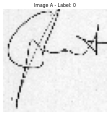

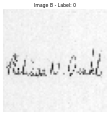

In [56]:
import matplotlib.pyplot as plt

# Extract two images and their labels
n = 3
img_A, img_B = test_data[0], test_data[n]
label_A, label_B = test_labels[0], test_labels[n]

# Display the labels
print(f"Label A: {label_A}, Label B: {label_B}")

# Plot the first image
plt.figure(dpi=28)
plt.imshow(img_A, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title(f"Image A - Label: {label_A}")
plt.axis('off')  # Turn off axis for better visualization
plt.show()

# Plot the second image
plt.figure(dpi=28)
plt.imshow(img_B, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title(f"Image B - Label: {label_B}")
plt.axis('off')  # Turn off axis for better visualization
plt.show()


In [21]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to preprocess a single image
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Unable to read the image at {image_path}")
    
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize to 64x64
    image = cv2.resize(image, (64, 64))
    
    # Normalize pixel values
    image = image / 255.0
    
    # Reshape to include batch and channel dimensions
    image = image.reshape((1, 64, 64, 1))
    
    return image

# Load the trained model
# model = load_model("saved_model/model.h5")
loaded_model = load_model("saved_model")

# Input two image paths
image_path_A = "signatures/full_forg/forgeries_1_20.png"
image_path_B = "signatures/full_org/original_1_20.png"

# Preprocess the images
img_A = preprocess_image(image_path_A)
img_B = preprocess_image(image_path_B)

# Predict similarity score
similarity_score = loaded_model.predict([img_A, img_B]).flatten()[0]

# Output results
print(f"Similarity score: {similarity_score}")
is_similar = similarity_score > 0.5
print(f"Are the images similar? {'Yes' if is_similar else 'No'}")


1/1 [==============================] - 0s 170ms/step
Similarity score: 1.3482549547916278e-05
Are the images similar? No
